# Data visualization

This test allows us to corroborate the proper interpretation of the data of the spectral energy distributions coming from the active galaxies in the example.

## SED plots from example (AGNfitter v1.0)

In [86]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
# Data format
# Name, redshift, wavelength [x10**(-10)], Intensity [Jy], data uncertainty [Jy] and so on and so forth
SED = np.loadtxt("catalog_example.txt")

f = (3*10**8)/(SED[0, 2::3]*10**(-10)) # Frequency [Hz]
datos = SED[0, 3::3]   # Intensity [Jy]
error = SED[0, 4::3]   # Uncertainty [Jy]


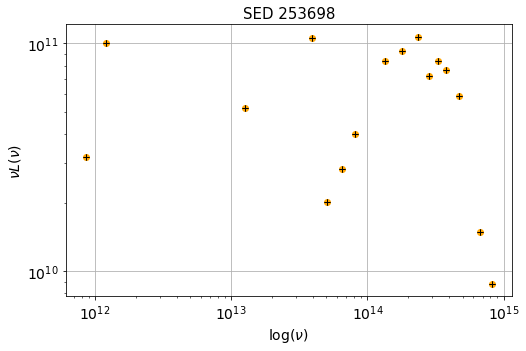

In [3]:
fig = plt.figure(figsize=(8, 5))
plt.ylabel(r'$\nu L(\nu)$', fontsize = 14) 
plt.xlabel(r'log($\nu$) ', fontsize = 14) 
plt.loglog(f[1:-1], f[1:-1]*datos[1:-1],color = 'orange', marker = 'o', linestyle = '')
(_, caps, _) = plt.errorbar(f[1:-1],  f[1:-1]*datos[1:-1], yerr=  error[1:-1], xerr = 0,  fmt='o', markersize=0, capsize=3, color = 'black')
for cap in caps:
    cap.set_markeredgewidth(1)
plt.grid() 
plt.title('SED 253698', fontsize = 15)
plt.xticks(size = 14)
plt.yticks(size = 14)
plt.show()

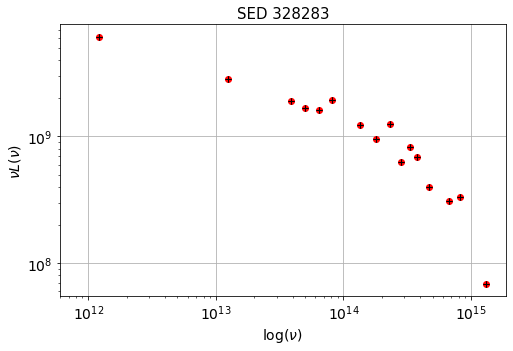

In [4]:
f2 = (3*10**8)/(SED[1, 2::3]*10**(-10))  # Frequency [Hz]
datos2 = SED[1, 3::3]   # Intensity [Jy]
error2 = SED[1, 4::3]   # Uncertainty [Jy]

fig = plt.figure(figsize=(8, 5))
plt.ylabel(r'$\nu L(\nu)$', fontsize = 14) 
plt.xlabel(r'log($\nu$) ', fontsize = 14) 
plt.loglog(f2[0:-1], f2[0:-1]*datos2[0:-1],color = 'r', marker = 'o', linestyle = '')
(_, caps, _) = plt.errorbar(f2[0:-1],  f2[0:-1]*datos2[0:-1], yerr=  error2[0:-1], xerr = 0,  fmt='o', markersize=0, capsize=3, color = 'black')
for cap in caps:
    cap.set_markeredgewidth(1)
plt.grid() 
plt.title('SED 328283', fontsize = 15)
plt.xticks(size = 14)
plt.yticks(size = 14)
plt.show()

## Plot of a telescope filter

In [5]:
# Subaru telescope transfer function (optical and IR)
Subaru_B = pd.read_csv("B_subaru.res", sep="  ", decimal=".", names = ['l_onda', 'I'], skiprows = 0, engine='python')

lo_filtro = Subaru_B['l_onda']*10**(-1) # wavelength [nm]
I = Subaru_B['I'] # Intensity

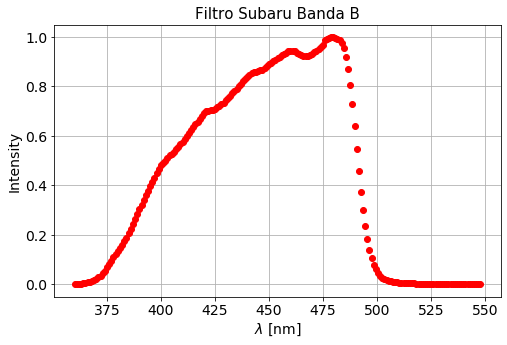

In [6]:
fig = plt.figure(figsize=(8, 5))
plt.ylabel(r'Intensity', fontsize = 14) 
plt.xlabel(r'$\lambda$ [nm]', fontsize = 14) 
plt.plot(lo_filtro, I ,color = 'r', marker = 'o', linestyle = '')
plt.grid() 
plt.title('Filtro Subaru Banda B', fontsize = 15)
plt.xticks(size = 14)
plt.yticks(size = 14)
plt.show()

## Plots of Brown data

In [7]:
# Data format
# Number, Name, redshift, wavelength [x10**(-10)], Intensity [Jy], data uncertainty [Jy] and so on and so forth
SED_Brown_obs = pd.read_csv("Datos Brown/brown2018_obs_agnfitter.txt", delim_whitespace=True, decimal=".", skiprows = 0)

The SEDs of the first 5 galaxies will be plotted.

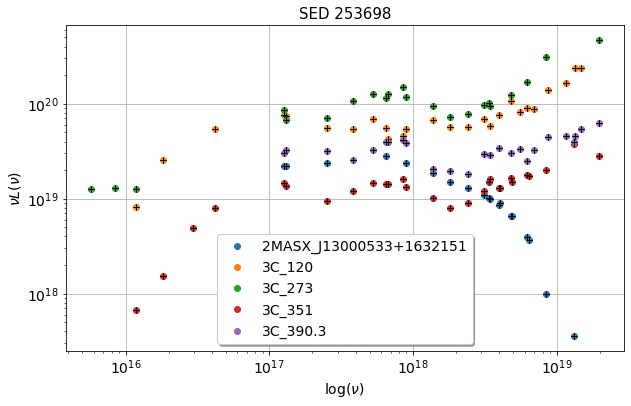

In [25]:
fig = plt.figure(figsize=(10, 6))
plt.ylabel(r'$\nu L(\nu)$', fontsize = 14) 
plt.xlabel(r'log($\nu$) ', fontsize = 14) 

for i in range(0,5):
    f = (3*10**8)/(SED_Brown_obs.iloc[i, 3::3]*10**(-10))  # Frequency [Hz]
    data = SED_Brown_obs.iloc[i, 4::3]   # Intensity [Jy]
    error = SED_Brown_obs.iloc[i, 5::3]   # Uncertainty [Jy]
    name = SED_Brown_obs.iloc[i, 1]
    
    plt.loglog(f, [f[i]*data[i] for i in range(len(f))], marker = 'o', linestyle = '', label = str(name))
    (_, caps, _) = plt.errorbar(f,  [f[i]*data[i] for i in range(len(f))], yerr=  error, xerr = 0,  fmt='o', markersize=0, capsize=3, color = 'black')
    for cap in caps:
        cap.set_markeredgewidth(1)
        
plt.grid() 
plt.title('SED 253698', fontsize = 15)
plt.legend(fontsize = 14, shadow = True, loc=8)
plt.xticks(size = 14)
plt.yticks(size = 14)
plt.show()

In [28]:
# Data format
# Number, Name, redshift, wavelength [x10**(-10)], Intensity [Jy], data uncertainty [Jy] and so on and so forth
SED_Brown_syn = pd.read_csv("Datos Brown/brown2018_syn_agnfitter-2.txt", delim_whitespace=True, decimal=".", skiprows = 0)

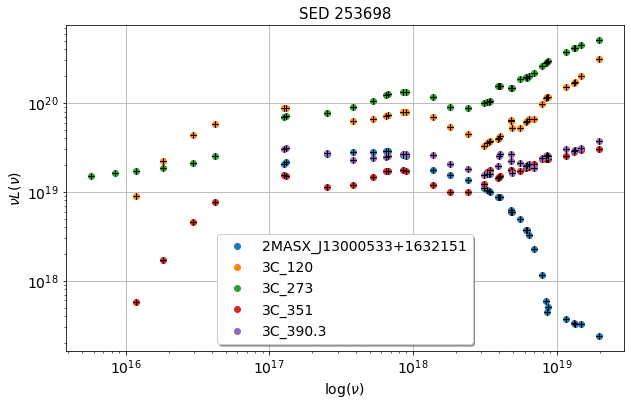

In [29]:
fig = plt.figure(figsize=(10, 6))
plt.ylabel(r'$\nu L(\nu)$', fontsize = 14) 
plt.xlabel(r'log($\nu$) ', fontsize = 14) 

for i in range(0,5):
    f = (3*10**8)/(SED_Brown_syn.iloc[i, 3::3]*10**(-10))  # Frequency [Hz]
    data = SED_Brown_syn.iloc[i, 4::3]   # Intensity [Jy]
    error = SED_Brown_syn.iloc[i, 5::3]   # Uncertainty [Jy]
    name = SED_Brown_syn.iloc[i, 1]
    
    plt.loglog(f, [f[i]*data[i] for i in range(len(f))], marker = 'o', linestyle = '', label = str(name))
    (_, caps, _) = plt.errorbar(f,  [f[i]*data[i] for i in range(len(f))], yerr=  error, xerr = 0,  fmt='o', markersize=0, capsize=3, color = 'black')
    for cap in caps:
        cap.set_markeredgewidth(1)
        
plt.grid() 
plt.title('SED 253698', fontsize = 15)
plt.legend(fontsize = 14, shadow = True, loc=8)
plt.xticks(size = 14)
plt.yticks(size = 14)
plt.show()

## Dictionaries handling

To understand and redefine the line 142 in RUN_AGNfitter_multi.py

In [81]:
# Dictionary similar to FILTERS_settings() in SETTINGS_AGNfitter.py
filters_settings = dict(z = np.array([0.894, 2.43, 0.731]), path= 'models/FILTERS/', SPIRE500 = [True, 29], Ks_VISTA = [False, 3], r_SDSS= [True, 4], add_filters = False)
filters_settings.keys()

dict_keys(['z', 'path', 'SPIRE500', 'Ks_VISTA', 'r_SDSS', 'add_filters'])

In [83]:
# To choose the type non-booleans values with first position == True --> Filters
[filters_settings[i] for i in filters_settings.keys() if type(filters_settings[i]) != bool and filters_settings[i][0] == True]

[[True, 29], [True, 4]]

In [85]:
# To count and choose the type list values with first position == True --> Filters
print(len([filters_settings[i] for i in filters_settings.keys() if type(filters_settings[i]) == list and filters_settings[i][0] == True]))

# To corroborate that these are filters
print([i for i in filters_settings.keys() if type(filters_settings[i]) == list and filters_settings[i][0] == True])

2
['SPIRE500', 'r_SDSS']


## SED plots from example (AGNfitter v2.0)

In [95]:
# Data format
# Name, redshift, Intensity [Jy], data uncertainty [Jy] and so on and so forth
SED2 = np.loadtxt("catalog_example2.txt")

l_c = [1516, 2304, 3591, 4723, 6213, 7523, 8855, 4866, 6215, 7545, 8679, 9633, 8798, 10214, 12535, 16453, 21540, 10319, 12510, 16377, 22083, 33792, 46293, 123337, 222532, 1036929, 1697692, 2493709, 3499071, 5041086]
f = [(3*10**8)/(i*10**(-10)) for i in l_c] # Frequency [Hz]
datos = SED2[2, 2::2]   # Intensity [Jy]
error = SED2[2, 3::2]   # Uncertainty [Jy]

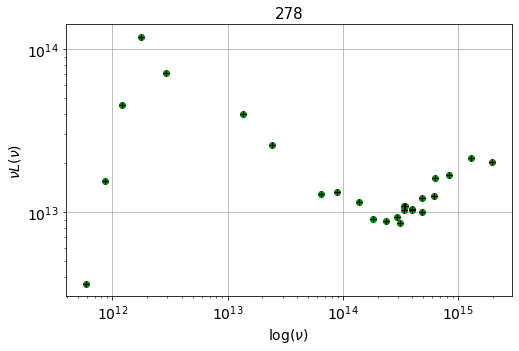

In [98]:
fig = plt.figure(figsize=(8, 5))
plt.ylabel(r'$\nu L(\nu)$', fontsize = 14) 
plt.xlabel(r'log($\nu$) ', fontsize = 14) 
plt.loglog(f, f*datos,color = 'g', marker = 'o', linestyle = '')
(_, caps, _) = plt.errorbar(f,  f*datos, yerr=  error, xerr = 0,  fmt='o', markersize=0, capsize=3, color = 'black')
for cap in caps:
    cap.set_markeredgewidth(1)
plt.grid() 
plt.title('278', fontsize = 15)
plt.xticks(size = 14)
plt.yticks(size = 14)
plt.show()

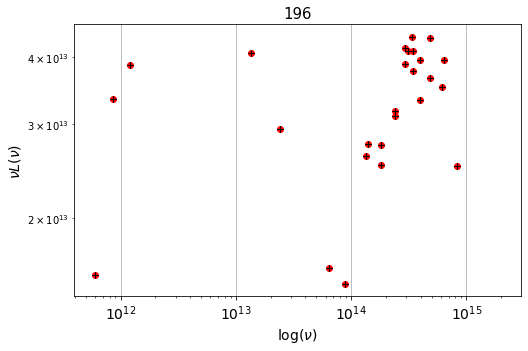

In [101]:
datos2 = SED2[1, 2::2]   # Intensity [Jy]
error2 = SED2[1, 3::2]   # Uncertainty [Jy]

fig = plt.figure(figsize=(8, 5))
plt.ylabel(r'$\nu L(\nu)$', fontsize = 14) 
plt.xlabel(r'log($\nu$) ', fontsize = 14) 
plt.loglog(f, f*datos2,color = 'r', marker = 'o', linestyle = '')
(_, caps, _) = plt.errorbar(f,  f*datos2, yerr=  error2, xerr = 0,  fmt='o', markersize=0, capsize=3, color = 'black')
for cap in caps:
    cap.set_markeredgewidth(1)
plt.grid() 
plt.title('196', fontsize = 15)
plt.xticks(size = 14)
plt.yticks(size = 14)
plt.show()